#**DATA PREPROCESSING AND FEATURE ENGINEERING IN MACHINE LEARNING**

##**Importing required libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

##**1. Data Exploration and Preprocessing:**

* Loading a dataset

In [2]:
df = pd.read_csv("/content/adult_with_headers.csv")
print(df.info())
print(df.describe(include='all'))
print("Missing values per column:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education_num  \
count   32561.0

* Handle Missing Values

In [3]:
df_clean = df.dropna()

removes all rows with missing values from the DataFrame, resulting in a cleaned dataset with only complete records.

* Train/Test Split (before scaling!)

In [4]:
# Check counts after outlier removal
class_counts = df_clean['income'].value_counts()
print(class_counts[class_counts < 2])

# Remove rare classes with count less than 2
valid_classes = class_counts[class_counts >= 2].index
df_filtered = df_clean[df_clean['income'].isin(valid_classes)]

X = df_filtered.drop('income', axis=1)  # feature matrix
y = df_filtered['income']  # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Series([], Name: count, dtype: int64)


* Scaling Pipelines

In [5]:
scaling_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain',
                'capital_loss', 'hours_per_week']

# Standard Scaling
std_scaler = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[scaling_cols] = std_scaler.fit_transform(X_train[scaling_cols])
X_test_std[scaling_cols] = std_scaler.transform(X_test[scaling_cols])

# Min-Max Scaling
mm_scaler = MinMaxScaler()
X_train_mm = X_train.copy()
X_test_mm = X_test.copy()
X_train_mm[scaling_cols] = mm_scaler.fit_transform(X_train[scaling_cols])
X_test_mm[scaling_cols] = mm_scaler.transform(X_test[scaling_cols])


* Confirm Scaled Outputs

In [6]:
print("Standard Scaled train numeric stats:\n", X_train_std[scaling_cols].describe().round(2))
print("Min-Max Scaled train numeric stats:\n", X_train_mm[scaling_cols].describe().round(2))


Standard Scaled train numeric stats:
             age    fnlwgt  education_num  capital_gain  capital_loss  \
count  22792.00  22792.00       22792.00      22792.00      22792.00   
mean       0.00     -0.00           0.00         -0.00          0.00   
std        1.00      1.00           1.00          1.00          1.00   
min       -1.58     -1.66          -3.50         -0.15         -0.22   
25%       -0.78     -0.68          -0.42         -0.15         -0.22   
50%       -0.12     -0.11          -0.03         -0.15         -0.22   
75%        0.62      0.45           0.74         -0.15         -0.22   
max        3.77     12.23           2.29         13.58         10.64   

       hours_per_week  
count        22792.00  
mean            -0.00  
std              1.00  
min             -3.18  
25%             -0.04  
50%             -0.04  
75%              0.36  
max              4.71  
Min-Max Scaled train numeric stats:
             age    fnlwgt  education_num  capital_gain  capi

When to use each scaling technique:

**Standard Scaling:**

* Centers data around 0 (mean = 0, std = 1).

* Ideal for linear models, PCA, SVM, k-means clustering etc., which assume centered/scaled input.

* Handles outliers better than Min-Max since data range isn't compressed to [0,1].

**Min-Max Scaling:**

* Rescales data to range [0, 1].

* Useful for neural networks, especially with activation functions (e.g., sigmoid, ReLU).

* Necessary when feature ranges differ vastly and you want to preserve relative distributions.

* Sensitive to outliers since extreme values define the range.

##**2. Encoding Techniques:**

In [7]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [8]:
# Step 1: Identify categorical columns and their unique counts
cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_counts = df[cat_cols].nunique()
print(cat_counts)


workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    42
income             2
dtype: int64


In [9]:
# Step 2: Split columns by cardinality
low_card = cat_counts[cat_counts < 5].index.tolist()
high_card = cat_counts[cat_counts > 5].index.tolist()
print("One-hot:", low_card)
print("Label:", high_card)


One-hot: ['sex', 'income']
Label: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'native_country']


In [10]:
# Step 3: Apply One-Hot Encoding to low-cardinality variables
ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop first to avoid dummy trap
ohe_df = pd.DataFrame(ohe.fit_transform(df[low_card]),
                      columns=ohe.get_feature_names_out(low_card),
                      index=df.index)


In [11]:
# Step 4: Apply Label Encoding to high-cardinality variables
le_df = df[high_card].apply(LabelEncoder().fit_transform)


In [12]:

# Step 5: Assemble final dataset
df_encoded = pd.concat([
    df.drop(columns=low_card + high_card),
    ohe_df,
    le_df
], axis=1)

print(df_encoded.head())


   age  fnlwgt  education_num    race  capital_gain  capital_loss  \
0   39   77516             13   White          2174             0   
1   50   83311             13   White             0             0   
2   38  215646              9   White             0             0   
3   53  234721              7   Black             0             0   
4   28  338409             13   Black             0             0   

   hours_per_week  sex_ Male  income_ >50K  workclass  education  \
0              40        1.0           0.0          7          9   
1              13        1.0           0.0          6          9   
2              40        1.0           0.0          4         11   
3              40        1.0           0.0          4          1   
4              40        0.0           0.0          4          9   

   marital_status  occupation  relationship  native_country  
0               4           1             1              39  
1               2           4             0         

**Pros & Cons of Each Technique:**

**1.One-Hot Encoding:**

* Pros:

  * Avoids implied order—ideal for nominal categories (e.g., color, city)

  * Supports distance-based models (logistic regression, neural networks)


* Cons:

  * Increases dimensionality; may lead to sparsity and computational overhead if many categories

  * Can cause multicollinearity if dummy variables aren’t dropped

**2.Label Encoding:**

* Pros:

  * Compact—saves memory, handles high-cardinality efficiently

  * Natural fit for ordinal features (e.g., “Low/Medium/High”)

  * Suits tree-based models that don’t assume numeric ordering

* Cons:

  * Implies false ranking for nominal categories, which can mislead linear models

  * Sometimes inconsistent with unseen categories during deployment; requires careful handling


##**3. Feature Engineering:**

*  Step 1: Load Data & Explore Skewness

In [13]:
from scipy.stats import skew
num_cols = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
print(df[num_cols].skew())

age                0.558743
fnlwgt             1.446980
education_num     -0.311676
capital_gain      11.953848
capital_loss       4.594629
hours_per_week     0.227643
dtype: float64


calculates and outputs the skewness for specified numerical columns in a DataFrame, including age, final weight, education number, capital gain, capital loss, and hours per week, using the scipy.stats skew function to assess their asymmetry.

* Step 2: Create 2 New Features

In [14]:
# 2.1 Net capital (gain minus loss)
df['net_capital'] = df['capital_gain'] - df['capital_loss']

# 2.2 Work hours per age ratio
df['hours_per_age'] = df['hours_per_week'] / df['age']
# If age = 0 somehow, add epsilon or filter


computes two new features in the DataFrame: net capital by subtracting capital loss from capital gain, and the work hours per age ratio by dividing hours per week by age, with a consideration to handle cases where age could be zero.

* Step 3: Log-Transform Skewed Variables

In [15]:
# Add 1 to avoid log(0)
df['log_capital_gain'] = np.log1p(df['capital_gain'])
df['log_capital_loss'] = np.log1p(df['capital_loss'])
df['log_net_capital'] = np.log1p(df['net_capital'].clip(lower=0))


creates new logarithmic features by applying the log(1 + x) transformation to capital gain, capital loss, and net capital (clipped to non-negative values), to handle skewness and stabilize variance for further analysis.



##**4. Feature Selection:**

* Removing Outliers with Isolation Forest

In [16]:
from sklearn.ensemble import IsolationForest

Imports the IsolationForest class from the sklearn.ensemble module, which is used for anomaly detection by isolating outliers in data through a tree-based ensemble method.

In [17]:
# Only use numeric features for outlier detection
num_cols = df.select_dtypes(include='number').columns

# Fit Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = iso.fit_predict(df[num_cols])

# Remove outliers (anomaly = -1 are outliers)
df_clean = df[df['anomaly'] == 1].drop(columns=['anomaly'])
print("Removed", (df['anomaly'] == -1).sum(), "outliers")

Removed 326 outliers


selects numeric features from a DataFrame for outlier detection using the Isolation Forest algorithm with a contamination rate of 1%. It fits the model to the numeric data, predicts anomalies, and labels them in a new column. Outliers identified as -1 are removed from the dataset, resulting in a cleaned DataFrame, with the total number of removed outliers printed.

* Relationship Analysis: PPS vs. Correlation

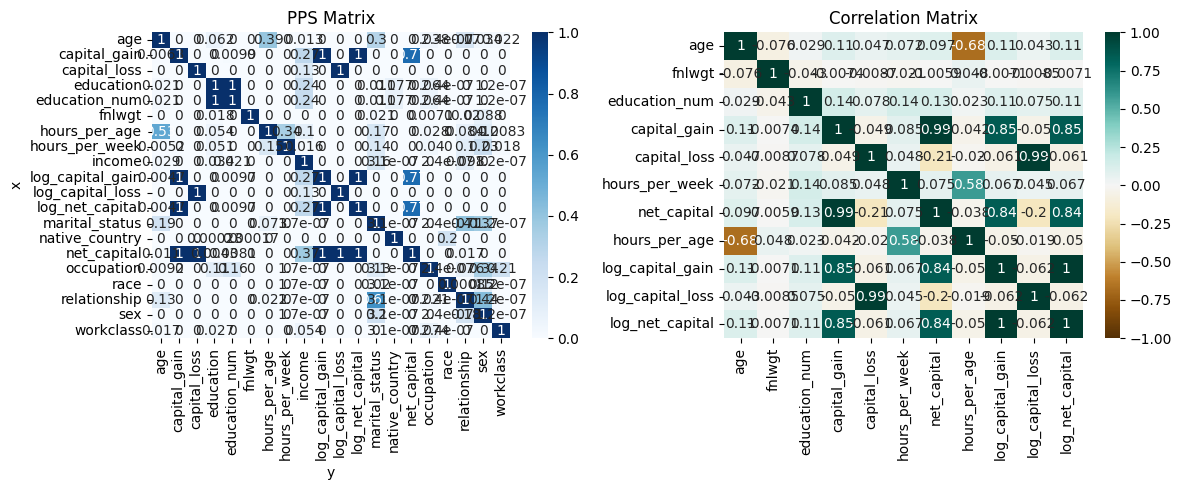

In [18]:
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Compute PPS matrix
pps_matrix = pps.matrix(df_clean)

# Compute correlation (only numeric columns)
corr_matrix = df_clean.select_dtypes(include='number').corr()

# Plot heatmaps
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(pps_matrix.pivot(index='x', columns='y', values='ppscore'),
            vmin=0, vmax=1, cmap='Blues', annot=True)
plt.title('PPS Matrix')

plt.subplot(1,2,2)
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='BrBG', annot=True)
plt.title('Correlation Matrix')
plt.tight_layout()


In [19]:
#%pip uninstall numpy -y
#%pip install numpy<2.0.0

In [ ]:
#!pip uninstall numpy -y
#!pip install numpy<2.0.0

In [ ]:
#%pip install ppscore

By importing libraries including ppscore for calculating predictive relationships between variables, seaborn and matplotlib.pyplot for data visualization, and suppresses warnings to ensure a clean output. It computes the PPS matrix for the cleaned dataset (df_clean), which assesses the predictive strength of one feature over another, providing insights beyond simple correlation. The code also prepares to visualize the relationships among numeric variables through a heatmap of their correlation matrix, with a specified color palette, value range, and annotations for clarity. The visualization aims to highlight the strength and direction of linear relationships between features, aiding in understanding feature dependencies and informing further analysis steps

##**Conclusion:**

Based on the steps performed in this notebook, we have successfully loaded and explored the dataset, handled missing values, split the data into training and testing sets, applied different scaling techniques to numerical features, and encoded categorical features using both One-Hot and Label Encoding. We also engineered new features and removed outliers using Isolation Forest. Finally, we visualized the relationships between features using correlation and PPS matrices, gaining insights into how different variables relate to each other and the target variable. These preprocessing and feature engineering steps are crucial for preparing the data for building effective machine learning models.



In [ ]:
#!pip install --force-reinstall pandas
#!pip install --force-reinstall numpy
#!pip install ppscore

  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.0 MB)
Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl (229 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
Using cached six-1.17.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstal

  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
^C
